### Analysis of Go.com transactions in Q1

In [2]:
import pandas as pd

#### Read in and format data

This dataframe should have one row for each day in Q1, and one column for each product line.  The values represent sales for a given day and product line, in dollars. 

In [247]:
q1 = pd.read_excel("go_data.xlsx", skiprows=3, header=1).drop("Unnamed: 0", axis=1)

In [270]:
def fmt(df):
    return df.drop("Unnamed: 0", axis=1).rename(columns={"Unnamed: 1": "Product Line"}).set_index("Product Line").T

historical_raw = pd.read_excel("go_data.xlsx", sheetname="Historical Data", skiprows=4, header=1)
historical_revenue = fmt(historical_raw.iloc[1:4])
historical_profit = fmt(historical_raw.iloc[-4:-1])

Examine DataFrames

In [271]:
print("Sales Data\nRows: {}\nColumns: {}".format(*q1.shape))

Sales Data
Rows: 256
Columns: 3


In [272]:
q1.head()

,Date,Revenue,Product Line
0,2015-01-01,108632.400,Cars.go.com
1,2015-01-01,31494.015,Planes.go.com
2,2015-01-01,239376.480,Boats.go.com
3,2015-01-02,552064.800,Cars.go.com
4,2015-01-02,238344.120,Planes.go.com


In [273]:
historical_revenue.applymap("${:,.2f}".format)

Product Line,Cars.go.com,Planes.go.com,Boats.go.com
Q4 2013,"$6,085,063.00","$32,339,403.00","$4,329,578.00"
Q1 2014,"$5,663,582.00","$34,861,524.00","$4,418,088.00"
Q2 2014,"$5,701,994.00","$36,039,564.00","$4,657,184.00"
Q3 2014,"$5,691,910.00","$34,422,242.00","$4,597,765.00"
Q4 2014,"$5,906,352.00","$45,337,642.00","$5,437,214.00"


In [274]:
historical_profit.applymap("${:,.2f}".format)

Product Line,Cars.go.com,Planes.go.com,Boats.go.com
Q4 2013,"$608,506.30","$161,697.02","$86,591.56"
Q1 2014,"$566,358.20","$174,307.62","$88,361.76"
Q2 2014,"$570,199.40","$180,197.82","$93,143.68"
Q3 2014,"$569,191.00","$172,111.21","$91,955.30"
Q4 2014,"$590,635.20","$226,688.21","$108,744.28"


#### Examine Trends in Historical Data

Planes has typically accounted for the lions share of revenue, but cars accounts for the majority of the profit

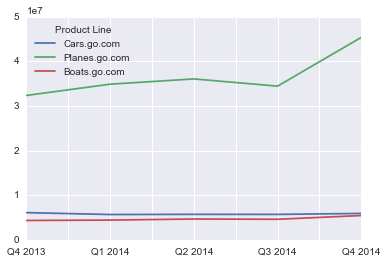

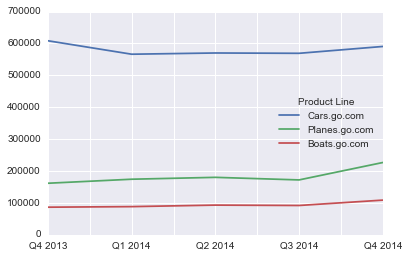

In [275]:
historical_revenue.plot(), historical_profit.plot();

All product lines had strong fourth quarters, but Planes is the fastest growing segment but a healthy margin

In [306]:
historical_profit.pct_change().applymap("{:.2%}".format).iloc[1:]

Product Line,Cars.go.com,Planes.go.com,Boats.go.com
Q1 2014,-6.93%,7.80%,2.04%
Q2 2014,0.68%,3.38%,5.41%
Q3 2014,-0.18%,-4.49%,-1.28%
Q4 2014,3.77%,31.71%,18.26%


Profit margins are constant.  Assuming that this holds true for Q1, this can be used to calculate profits from Q1 sales data

In [299]:
profit_margin = historical_revenue / historical_profit
profit_margin

Product Line,Cars.go.com,Planes.go.com,Boats.go.com
Q4 2013,10.0,200.0,50.0
Q1 2014,10.0,200.0,50.0
Q2 2014,10.0,200.0,50.0
Q3 2014,10.0,200.0,50.0
Q4 2014,10.0,200.0,50.0


#### Explore Summary Statistics for Q1

In [161]:
grouper = q1.groupby("Product Line")

Planes.go.com accounts for the lions share of revenue.  Boats.go.com contributes significantly less revenue than the other two segments

In [164]:
total_revenue = grouper.sum()
total_revenue.loc['Total'] = total_revenue.sum()
total_revenue['%'] = total_revenue / total_revenue.loc['Total']
total_revenue

,Revenue,%
Product Line,,
Boats.go.com,4736347.68,0.087672
Cars.go.com,16757524.80,0.310189
Planes.go.com,32529742.56,0.602139
Total,54023615.04,1.000000


Boats.com also has 14 fewer records than Cars and Planes. The other two segments appear to have complete records. What is causing this discrepency, and what impact does it have on the profitability of segment?

In [165]:
summary = grouper.describe().unstack()
summary.columns = summary.columns.droplevel()
summary.applymap("{:,.2f}".format)

,count,mean,std,min,25%,50%,75%,max
Product Line,,,,,,,,
Boats.go.com,76.00,"62,320.36","67,050.57",251.04,"21,141.36","36,744.72","59,522.28","239,376.48"
Cars.go.com,90.00,"186,194.72","158,793.62","3,790.80","75,800.40","111,863.40","285,843.60","571,988.40"
Planes.go.com,90.00,"361,441.58","351,150.91","6,999.61","118,879.35","214,161.57","605,310.77","1,395,072.31"


Verify that Cars and Planes have non-zero records for every day in the quarter.

In [202]:
df = q1.copy().set_index("Date")
df["Has Sales"] = df["Revenue"].apply(lambda x: 1 if x>0 else 0)

In [205]:
df.groupby("Product Line")["Has Sales"].sum()

Product Line
Boats.go.com     76
Cars.go.com      90
Planes.go.com    90
Name: Has Sales, dtype: int64

Data is missing for the Boats segment between 2/7/16 and 2/20/16.  Either the website not operating during this period, or is this a data quality issue.

In [214]:
set(df[df["Product Line"] == "Cars.go.com"].index) - set(df[df["Product Line"] == "Boats.go.com"].index)

{Timestamp('2015-02-07 00:00:00'),
 Timestamp('2015-02-08 00:00:00'),
 Timestamp('2015-02-09 00:00:00'),
 Timestamp('2015-02-10 00:00:00'),
 Timestamp('2015-02-11 00:00:00'),
 Timestamp('2015-02-12 00:00:00'),
 Timestamp('2015-02-13 00:00:00'),
 Timestamp('2015-02-14 00:00:00'),
 Timestamp('2015-02-15 00:00:00'),
 Timestamp('2015-02-16 00:00:00'),
 Timestamp('2015-02-17 00:00:00'),
 Timestamp('2015-02-18 00:00:00'),
 Timestamp('2015-02-19 00:00:00'),
 Timestamp('2015-02-20 00:00:00')}

#### Comparison of Q1 to Historical Data

In [325]:
historical_revenue.loc["Q1 2015"] = total_revenue['Revenue']
historical_revenue

Product Line,Cars.go.com,Planes.go.com,Boats.go.com
Q4 2013,6085063.0,32339403.00,4329578.00
Q1 2014,5663582.0,34861524.00,4418088.00
Q2 2014,5701994.0,36039564.00,4657184.00
Q3 2014,5691910.0,34422242.00,4597765.00
Q4 2014,5906352.0,45337642.00,5437214.00
Q1 2015,16757524.8,32529742.56,4736347.68


Because profit margins have been constant, we can use the historical data to map from revenue to profit

In [347]:
historical_profit = historical_revenue / profit_margin.values[0]
historical_profit["Total"] = historical_profit.T.sum().T

In [338]:
historical_profit.applymap("{:,.2f}".format)

Product Line,Cars.go.com,Planes.go.com,Boats.go.com,Total
Q4 2013,"608,506.30","161,697.02","86,591.56","856,794.88"
Q1 2014,"566,358.20","174,307.62","88,361.76","829,027.58"
Q2 2014,"570,199.40","180,197.82","93,143.68","843,540.90"
Q3 2014,"569,191.00","172,111.21","91,955.30","833,257.51"
Q4 2014,"590,635.20","226,688.21","108,744.28","926,067.69"
Q1 2015,"1,675,752.48","162,648.71","94,726.95","1,933,128.15"


In [357]:
profit_share = historical_profit.apply(lambda col: col / historical_profit["Total"])
profit_share

Product Line,Cars.go.com,Planes.go.com,Boats.go.com,Total
Q4 2013,0.710212,0.188723,0.101065,1.0
Q1 2014,0.683160,0.210256,0.106585,1.0
Q2 2014,0.675959,0.213621,0.110420,1.0
Q3 2014,0.683091,0.206552,0.110356,1.0
Q4 2014,0.637788,0.244786,0.117426,1.0
Q1 2015,0.866861,0.084138,0.049002,1.0


In [359]:
historical_profit.pct_change().applymap("{:.2%}".format)

Product Line,Cars.go.com,Planes.go.com,Boats.go.com,Total
Q4 2013,nan%,nan%,nan%,nan%
Q1 2014,-6.93%,7.80%,2.04%,-3.24%
Q2 2014,0.68%,3.38%,5.41%,1.75%
Q3 2014,-0.18%,-4.49%,-1.28%,-1.22%
Q4 2014,3.77%,31.71%,18.26%,11.14%
Q1 2015,183.72%,-28.25%,-12.89%,108.75%


Assessment: Strong Buy.

Go.com is expected to have a breakout quarter in Q1 2015, with profits increasing 108.75% from \$926,067 to \$1,933,128.15 quarter-over-quarter. This increase is primarily driven by the success of the retailer's Cars.go.com segment, which increased sales by 183.72% quarter-over-quarter, from \$590,635.20 in Q4 2014 to \$1,675,752.48.  

Cars.go.com's success carried the firm amid weaker performance in the Planes.go.com and Boats.go.com segments, which saw sales decline by 28.25% and 12.89% respectively.  It is worth noting that the available data contained a 14-day gap in Boats.go.com sales, between 2/7/16 and 2/20/16. This period of missing sales warrants further investigation, but is unlikely to materially affect the "Strong Buy" assessment, as Boats.go.com historically accounts for roughly 10% of Go.com's total profit.